BIG DATA IN BUSINESS AND INDUSTRY, PRACTICAL WORK\
Taru Haimi, 0565878\
Joona Ylijoki, 0522866

TASK: Create ML model to forecast user's next exercise type, time and, possibly, duration

In [1]:
#########################################
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pa_functions as pafuns

Loading data from json files into one dataframe.\
Source code: READ_workoutsToMoodle.py 

In [2]:
folderpath = r"C:\Users\joona\Desktop\LUT\Big Data in Business and Industry\PracticalAssignment\WorkoutData"
data = pd.DataFrame()
for file in os.listdir(folderpath):
    newdf = pafuns.read_file_to_df(os.path.join(folderpath, file))
    data = pd.concat([data, newdf], ignore_index=True)
data.reset_index(drop=True, inplace = True)

EXPLORATORY DATA ANALYSIS & DATA PREPROCESSING

- Finding out important variables
- Missing values handling?
- Encoding categorical variables
- Scaling 

1) Finding out all different types of sports

In [3]:
sporttypes = data["sport"].unique()
print(sporttypes)
print("Number of different sport types: ", len(data["sport"].unique()))

['WALKING' 'WEIGHT_TRAINING' 'RUNNING' 'SKIING_CROSS_COUNTRY' 'SWIMMING'
 'BADMINTON' 'ROLLER_SKATING' 'FITNESS_WALKING' 'CYCLING_SPORT' 'CROSSFIT'
 'RUNNING_CANICROSS' 'ICE_SKATING' 'BEACH_VOLLEY' 'CYCLING_TRANSPORTATION'
 'STAIR_CLIMBING' 'CROSS_TRAINING' 'STRETCHING']
Number of different sport types:  17


2. Exploring starting hours vs sports and their average duration.

These barplots describe relations between starting times and sport types, and in addition they show how the durations of activities vary between clock times and sports. It can be observed that only walking activities are started to record round the clock, 2am-10pm.  Then most notable is that beach volley, fitness walking and stretching have records only in single specific hours. Roller skating has also very specific starting times, between 8am-12am. Then many sports have pretty similar timeline starting from early morning and ending in late evenin. The exact starting and ending times vary between 4-9am and 5-8pm. 

** jotain keskiarvokeston vaihtelusta kellonaikojen ja urheilulajien välillä? **

Based on these notes, the starting time might be a good variable to estimate next exercise type, but certainly not alone. Some sports can occur only certain hours of the day which gives good limitations for model, but most of sports can occur same time of the day, so more features are definitely needed to estimate these hours. 


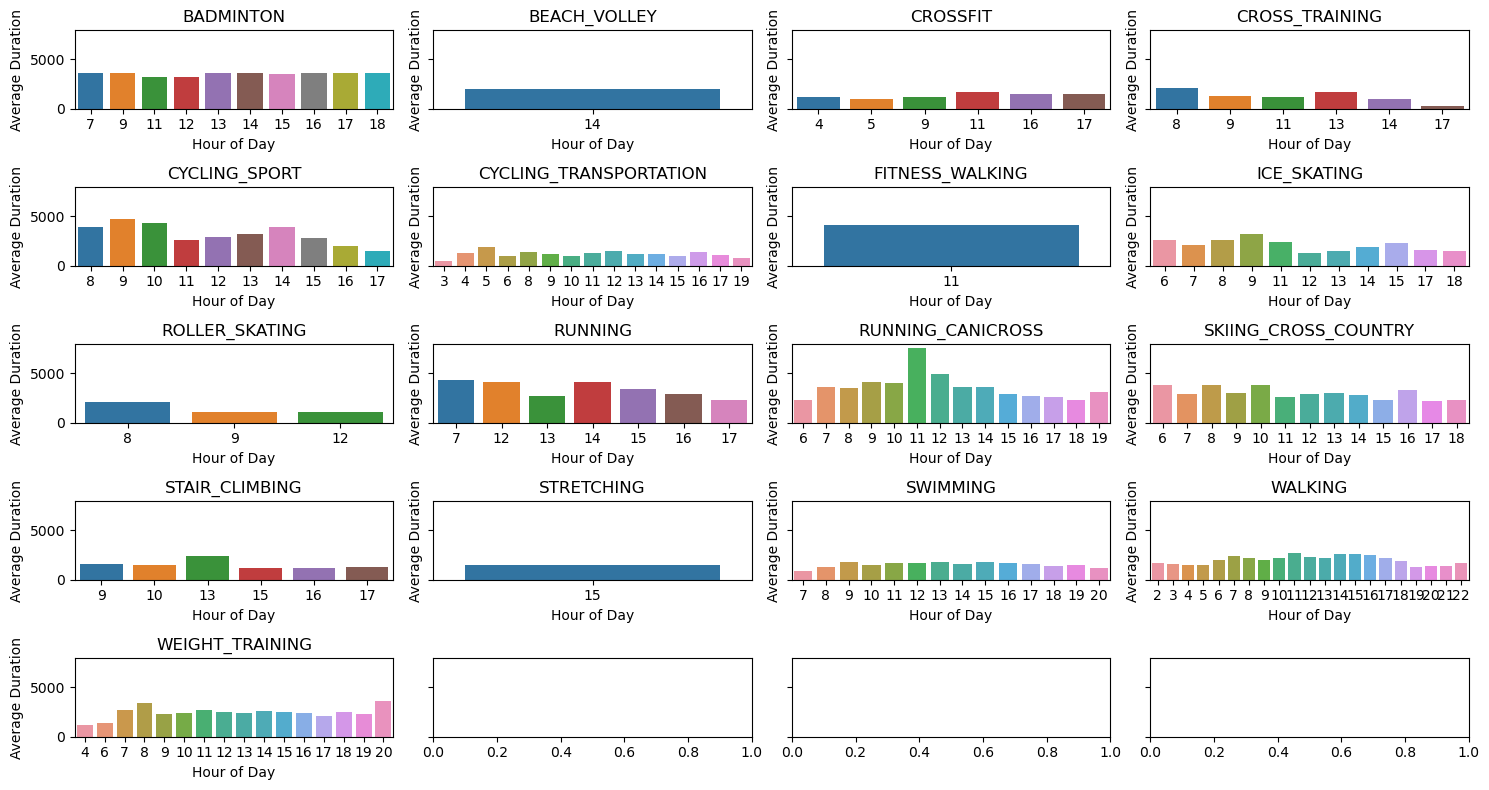

In [4]:
# Convert 'timestamp' column to datetime
data['start_time'] = pd.to_datetime(data['start_time'])

# Extract the hour from the timestamp
data['start_hour'] = data['start_time'].dt.hour

# Calculate the average duration for each hour and sport type
# hourlydata = data.copy()
mean_durations = data.groupby(['sport', 'start_hour'])['duration_s'].mean().reset_index()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 8), sharey=True)

# Flatten the 2D array of subplots
axes = axes.flatten()

# Iterate over sport types
for i, (sport, hourlydata) in enumerate(mean_durations.groupby('sport')):
    sns.barplot(x='start_hour', y='duration_s', data=hourlydata, ax=axes[i])
    axes[i].set_title(sport)
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Average Duration')

# Adjust layout
plt.tight_layout()
plt.show()

3. Exploring weekdays vs sports and their average duration.

These barplots tell on which weekdays certain sports have been recorded, and again also shows how the average durations are distributed between weekdays and sports. Most sports have records from every day or almost every day, but notable are those sports that have records only certain days. This kind of sports are stretching and beach volley. Additionally cross_training and roller_skating have limited weekdays to be recorded. Most of durations between weekdays in same sport type don’t vary a lot, but durations between sport types in same weekday are very different from each other.

The weekday might be a good variable to be used in model, since with it some possible sports can be cut off from options. For example, if other variables would estimate that the next sport is beach volley but it’s Wednesday, that sport probably is not the correct one. Also if the estimations showed that the duration of sport would be short, the sports with long average duration can be cut off. 


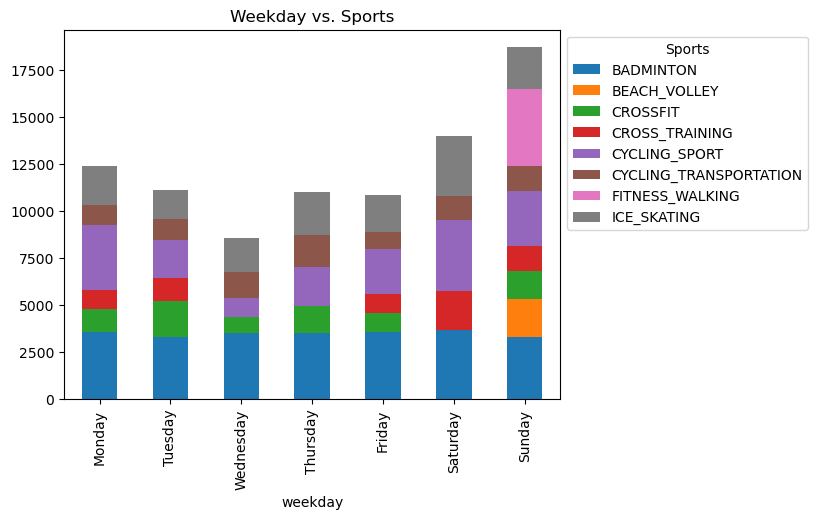

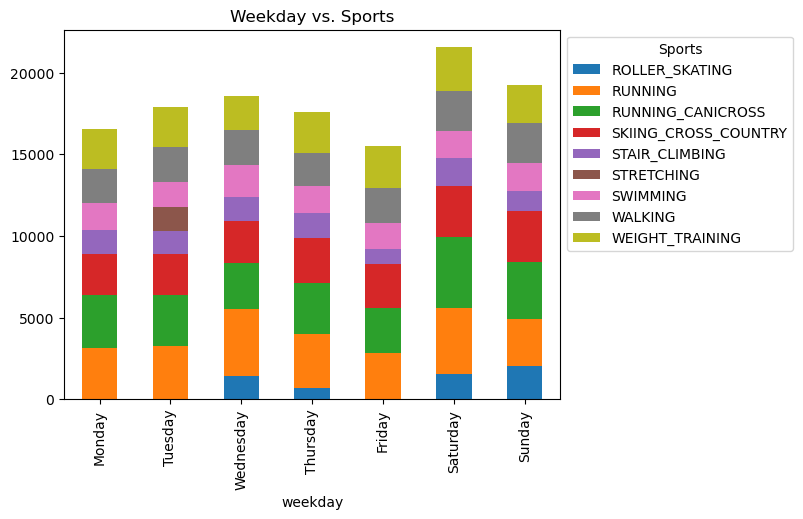

In [5]:
# Extract the weekday from the timestamp
data['weekday'] = data['start_time'].dt.weekday

# Calculate the average duration for each weekday and sport type
mean_durations = data.groupby(['sport', 'weekday'])['duration_s'].mean().reset_index()

# Pivot the data to have weekdays as columns
mean_durations_pivot = mean_durations.pivot(index='weekday', columns='sport', values='duration_s').reset_index()

# Plot the average duration per sport and  per weekday in two parts:
datapart1 =  mean_durations_pivot.iloc[:,list(range(0, 9))]
datapart2 = mean_durations_pivot.iloc[:, [0] + list(range(9, 18))]
pafuns.plot_weekday_data(datapart1)
pafuns.plot_weekday_data(datapart2)

4. Exploring seasons vs sports and their average duration.

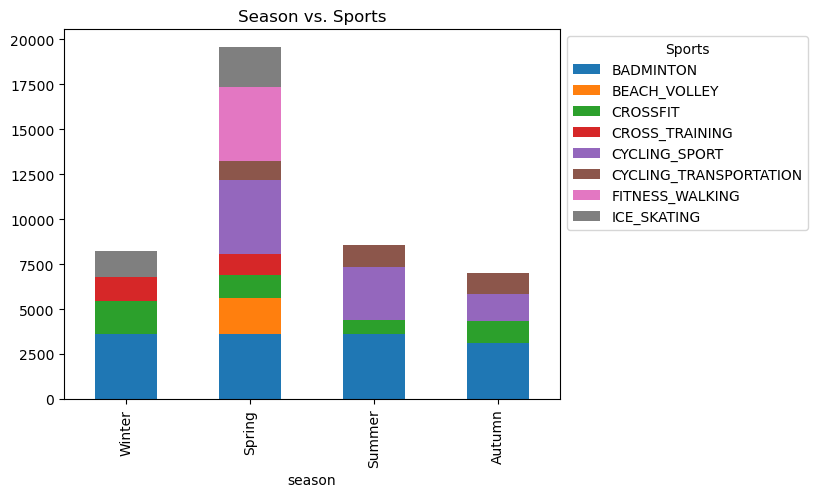

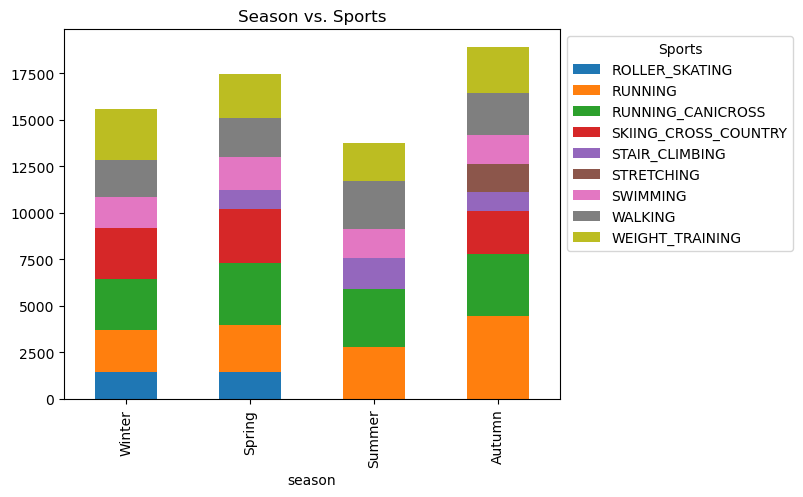

In [6]:
data['month'] = data['start_time'].dt.month
# Define a mapping from month to season
month_to_season = {
    12: '1',
    1: '1',
    2: '1',
    3: '2',
    4: '2',
    5: '2',
    6: '3',
    7: '3',
    8: '3',
    9: '4',
    10: '4',
    11: '4'
}
# Create a new column for seasons
data['season'] = data['month'].map(month_to_season)

# Calculate the average duration for each weekday and sport type
mean_durations = data.groupby(['sport', 'season'])['duration_s'].mean().reset_index()

# Pivot the data to have weekdays as columns
mean_durations_pivot = mean_durations.pivot(index='season', columns='sport', values='duration_s').reset_index()

# Plot the average duration per sport and  per weekday in two parts:
datapart1 =  mean_durations_pivot.iloc[:,list(range(0, 9))]
datapart2 = mean_durations_pivot.iloc[:, [0] + list(range(9, 18))]
pafuns.plot_season_data(datapart1)
pafuns.plot_season_data(datapart2)

Avg. Calories Burned (Kcal) w.r.t Sport (Heaviness of the exercise might be related to the resting period and the next exercise type). Therefore the burned calories might be a good variable to use in the model.

In [7]:

# Calculate the average burned calories for each sport type
mean_calories = data.groupby(['sport'])['calories_kcal'].mean().reset_index()
# Round the values to one decimal and store in a series
avg_calories = mean_calories['calories_kcal'].round(1)
# Store sport types in a series
sports = mean_calories['sport']

# Plot pie chart from average calories burned w.r.t each sport type
fig = px.pie(data_frame=mean_calories, names='sport', values=avg_calories, 
             title='Average Calories Burned by Sport Type')
# Add both 'sports' and 'avg_calories' with 'kcal' in the label
fig.update_traces(textposition='outside', texttemplate='%{label}: %{value: .1f} kcal',
                marker=dict(line=dict(color='#000000', width=1.5)))
# Adjust the legend position to the right
fig.update_layout(legend=dict(x=1.3, y=0.5), height=550, width=1150)
# Show the interactive pie chart
fig.show()



5. Exploring locations of sports

There're some observations of sports that are recorded outside of Finland. Their total count is however very small when compared to the whole data amount, and they all are sport type "walking". These are probably from holiday or work trips, and the person was just "walking around in a new city". These sport activities are quite probably very anomalous from normal life, so they can be excluded from the model because they are possible outliers and could give model wrong idea.

In [15]:
# Bounding box for Finland's coordinate
finland_bounding_box = {
    'min_latitude': 60,
    'max_latitude': 70,
    'min_longitude': 20,
    'max_longitude': 30,
}

# Check if each location is outside Finland
outside_finland = (
    (data['start_lat'] < finland_bounding_box['min_latitude']) |
    (data['start_lat'] > finland_bounding_box['max_latitude']) |
    (data['start_long'] < finland_bounding_box['min_longitude']) |
    (data['start_long'] > finland_bounding_box['max_longitude'])
)

# Locations outside Finland and their count
df_outside_finland = data[outside_finland]
print(f'Number of locations outside Finland: ' + str(len(df_outside_finland)))

outside_finland_indices = df_outside_finland.index
print(outside_finland_indices)

Number of locations outside Finland: 30
Int64Index([1402, 1403, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745,
            1746, 2135, 2136, 2137, 2139, 2147, 2148, 2149, 2150, 2151, 2152,
            2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160],
           dtype='int64')


In [17]:
#test_data = pd.DataFrame(data)
#test_data = test_data.drop(outside_finland_indices)
# From here onwards all 'data' has been replaced with 'test_data'
data = data.drop(outside_finland_indices)

Creating categorical dataframe for the input variables: changing the data to a format that the different categories that we will input into the model are numerical values. Doing this for the following variables: sport, duration, starting hour, kcal, weekday, month. Also creating shifted categories that represent the last exercise's type, time, kcal consumption, weekday, and month.

In [35]:
column_names = data.columns
print(column_names)

categorical_df = pd.DataFrame()

# Adding categorical variables to the DataFrame
categories = ['sport_category','duration_category_text','duration_sec_category','start_hour_category','kcal_category_text','kcal_category',
              'weekday_category','month_category', 'last_exercise_category', 'last_exercise_timing', 'last_exercise_kcal_category', 
              'last_exercise_weekday_category', 'last_exercise_month_category', 'start_hour_text_category']
#categorical_df['CategoricalColumn'] = pd.Categorical(categories)

# Create a mapping dictionary for each needed variable to categories
sport_type_to_category = {sport_type: category for category, sport_type in enumerate(sports)}
# Map sport types to categories and add them to the categorical DataFrame
categorical_df[categories[0]] = pd.Categorical(data['sport'].map(sport_type_to_category))
data['sport_type_category'] = categorical_df[categories[0]]

# Categories for duration (miten halutaan jakaa nuo rajat? Jos laittaa tasalukuina niin se tasaluku lukeutuu seuraavan intervallin sisään (esim. 30 min menee "max one hour").)
intervals = [0,11,31,61,121, float('inf')]
interval_labels = ['Max 10 mins', 'Max half an hour', 'Max one hour', 'Max two hours', 'Over two hours']
data['DurationsInMinutes'] = data['duration_s'] / 60
# Text categories
categorical_df[categories[1]] = pd.cut(data['DurationsInMinutes'], bins=intervals, labels=interval_labels, right=False)
# Numerical categories for duration [0, 1, 2, 3, 4]
duration_type_to_category = {duration_type: category for category, duration_type in enumerate(interval_labels)}
categorical_df[categories[2]] = pd.Categorical(categorical_df[categories[1]].map(duration_type_to_category))

# Create a mapping dictionary for start hour variable to categories
#starth_types = data["start_hour"].unique()
#starthour_type_to_category = {starthour_type: category for category, starthour_type in enumerate(starth_types)}
# Map sport types to categories and add them to the categorical DataFrame
#categorical_df[categories[3]] = pd.Categorical(data['start_hour'].map(starthour_type_to_category))
# More simple way (previous works too)
categorical_df[categories[3]] = data['start_hour']
# Making a text category with intervals for starting hour
intervals_hours = [0, 6, 11, 14, 17, 24]
intervals_hours_labels = ['Night', 'Morning', 'Noon', 'Afternoon', 'Evening']
categorical_df[categories[13]] = pd.cut(data['start_hour'], bins=intervals_hours, labels=intervals_hours_labels, right=False)

# Categories for burned kcal
interval_kcal = [0,101,201,301,401,501,601, float('Inf')]
interval_kcal_labels = ['Max 100 kcal', 'Max 200 kcal', 'Max 300 kcal', 'Max 400 kcal', 'Max 500 kcal', 'Max 600 kcal', 'Over 600 kcal']
# Text categories 
categorical_df[categories[4]] = pd.cut(data['calories_kcal'], bins=interval_kcal, labels=interval_kcal_labels, right=False)
# Numerical categories for burned calories [0, 1, 2, 3, 4, 5, 6]
kcal_type_to_category = {kcal_type: category for category, kcal_type in enumerate(interval_kcal_labels)}
categorical_df[categories[5]] = pd.Categorical(categorical_df[categories[4]].map(kcal_type_to_category))

# Weekday category
categorical_df[categories[6]] = data['weekday']

# Month category
categorical_df[categories[7]] = data['month']

# Adding the last activity/exercise type to each observation
categorical_df[categories[8]] = categorical_df['sport_category'].shift(fill_value=None)
# Adding the last activity/exercise timing to each observation
categorical_df[categories[9]] = categorical_df['start_hour_category'].shift(fill_value=None)
# Adding the last activity/exercise burned kcal to each observation
categorical_df[categories[10]] = categorical_df['kcal_category'].shift(fill_value=None)
# Adding the last activity/exercise weekday to each observation
categorical_df[categories[11]] = categorical_df['weekday_category'].shift(fill_value=None)
# Adding the last activity/exercise month to each observation
categorical_df[categories[12]] = categorical_df['month_category'].shift(fill_value=None)

#print(categorical_df)

Index(['sport', 'source', 'created_date', 'start_time', 'end_time',
       'duration_s', 'distance_km', 'calories_kcal', 'altitude_min_m',
       'altitude_max_m', 'speed_avg_kmh', 'speed_max_kmh', 'ascend_m',
       'descend_m', 'start_lat', 'start_long', 'end_lat', 'end_long',
       'hydration_l', 'start_hour', 'weekday', 'month', 'season',
       'sport_type_category', 'DurationsInMinutes'],
      dtype='object')


Cleaning categories: changing all the categorical_df dataframe columns to type int64, so that they all have integer number types. Extracting the text formatted columns from the DataFrame and creating the numerical_df DataFrame that is used in the model.

In [36]:
# Extracting the text categories from the categorical DataFrame
columns_to_remove = ['duration_category_text','kcal_category_text']
# Check if columns to remove exist in the DataFrame and remove them
for column in columns_to_remove:
    if column in categorical_df.columns:
        categorical_df.drop(column, axis=1, inplace=True)
print(categorical_df.dtypes)

# Convert all columns to type int64
numerical_df = pd.DataFrame()
for columns in categorical_df.columns:
    print(columns)
    numerical_df[columns] = categorical_df[columns].astype('category').cat.codes.astype('int64')
#categorical_df['sport_category'] = categorical_df['sport_category'].astype('category').cat.codes.astype('int64')
print(numerical_df.dtypes)


sport_category                    category
duration_sec_category             category
start_hour_category                float64
start_hour_text_category          category
kcal_category                     category
weekday_category                   float64
month_category                     float64
last_exercise_category            category
last_exercise_timing               float64
last_exercise_kcal_category       category
last_exercise_weekday_category     float64
last_exercise_month_category       float64
dtype: object
sport_category
duration_sec_category
start_hour_category
start_hour_text_category
kcal_category
weekday_category
month_category
last_exercise_category
last_exercise_timing
last_exercise_kcal_category
last_exercise_weekday_category
last_exercise_month_category
sport_category                    int64
duration_sec_category             int64
start_hour_category               int64
start_hour_text_category          int64
kcal_category                     int64
weekday_ca

Testing some ML models

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

# Features and target variables
X = numerical_df[['last_exercise_category', 'last_exercise_timing', 'last_exercise_kcal_category', 'last_exercise_weekday_category', 'last_exercise_month_category']]
y_type = numerical_df['sport_category']
y_time = numerical_df['start_hour_category']
y_duration = numerical_df['duration_sec_category']

# Split data into training and testing sets
X_train, X_test, y_type_train, y_type_test, y_time_train, y_time_test, y_duration_train, y_duration_test = train_test_split(
    X, y_type, y_time, y_duration, test_size=0.2, random_state=42)

# Random Forest Classifier for 'type'
type_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
type_classifier.fit(X_train, y_type_train)

# Random Forest Regressor for 'time'
time_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
time_regressor.fit(X_train, y_time_train)

# Random Forest Regressor for 'duration'
duration_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
duration_regressor.fit(X_train, y_duration_train)

# Make predictions
type_predictions = type_classifier.predict(X_test)
time_predictions = time_regressor.predict(X_test)
duration_predictions = duration_regressor.predict(X_test)

# Evaluate the models
type_accuracy = accuracy_score(y_type_test, type_predictions)
time_mse = mean_squared_error(y_time_test, time_predictions)
duration_mse = mean_squared_error(y_duration_test, duration_predictions)

print(f'Type Accuracy: {type_accuracy:.2f}')
print(f'Time Mean Squared Error: {time_mse:.2f}')
print(f'Duration Mean Squared Error: {duration_mse:.2f}')

Type Accuracy: 0.76
Time Mean Squared Error: 15.11
Duration Mean Squared Error: 0.54


Own input testing

In [39]:
from datetime import datetime

# Get the current date and time
current_time = datetime.now()
# Extract hours, minutes, day and month
current_hour = current_time.hour
current_minute = current_time.minute
current_day = current_time.day
current_month = current_time.month

# Selecting the own inputs
print(sports)
own_exercise = 'RUNNING'
own_exercise_category = data.set_index('sport')['sport_type_category'].get(own_exercise, None)
print(f'Own exercise category number:', own_exercise_category[0])

# The hour the last exercise was started 0-23
own_exercise_start_hour = 20

# Burned calories category: 'Max 100 kcal' = 0, 'Max 200 kcal' = 1, 'Max 300 kcal' = 2, 'Max 400 kcal' = 3, 'Max 500 kcal' = 4, 'Max 600 kcal' = 5, 'Over 600 kcal' = 6
own_exercise_burned_kcal_category = 0

# Own exercise weekday category: 'Monday' = 0, 'Tuesday' = 1, 'Wednesday' = 2, 'Thursday' = 3, 'Friday' = 4, 'Saturday' = 5, 'Sunday' = 6 
own_exercise_weekday_category = 0

# Own exercise month category: 1-12
own_exercise_month_category = 11

# Forming the own X variable
own_columns = ['last_exercise_category', 'last_exercise_timing', 'last_exercise_kcal_category', 'last_exercise_weekday_category', 'last_exercise_month_category']
X_own = pd.DataFrame(columns=own_columns)
new_observation = {'last_exercise_category': own_exercise_category[0], 'last_exercise_timing': own_exercise_start_hour, 'last_exercise_kcal_category': own_exercise_burned_kcal_category, 
                   'last_exercise_weekday_category': own_exercise_weekday_category, 'last_exercise_month_category': own_exercise_month_category}
X_own = pd.concat([X_own, pd.DataFrame([new_observation])], ignore_index=True)

# Make predictions
own_type_predictions = type_classifier.predict(X_own)
own_time_predictions = time_regressor.predict(X_own)
own_duration_predictions = duration_regressor.predict(X_own)

# Answers
next_sport = data.loc[data['sport_type_category'] == own_type_predictions.item(), 'sport'].values[0]
#next_sport_time = round(own_time_predictions.item())
next_sport_time = categorical_df.loc[categorical_df['start_hour_category'] == round(own_time_predictions.item()), 'start_hour_text_category'].values[0]
next_sport_duration = interval_labels[round(own_duration_predictions.item())]

print(f'Predicted sport type: {next_sport}')
print(f'Predicted exercise time: {next_sport_time}') # Tää saattaa nyt kyl olla category, koska alkuperäset alotusajat on 02-22 välillä 
# ja nää categoryt on numerical_df dataframes 0-20 eli en tiiä pitäskö tän ny sit olla klo 11? Vai haluttasko jakaa noi luokkiin 'Morning', 'Day', 'Afternoon', 'Evening', 'Night' tms.?
print(f'Predicted exercise duration: {next_sport_duration}')

0                  BADMINTON
1               BEACH_VOLLEY
2                   CROSSFIT
3             CROSS_TRAINING
4              CYCLING_SPORT
5     CYCLING_TRANSPORTATION
6            FITNESS_WALKING
7                ICE_SKATING
8             ROLLER_SKATING
9                    RUNNING
10         RUNNING_CANICROSS
11      SKIING_CROSS_COUNTRY
12            STAIR_CLIMBING
13                STRETCHING
14                  SWIMMING
15                   WALKING
16           WEIGHT_TRAINING
Name: sport, dtype: object
Own exercise category number: 9
Predicted sport type: WALKING
Predicted exercise time: Noon
Predicted exercise duration: Max one hour
